<a href="https://colab.research.google.com/github/Seligmann/carvana-image-masking-challenge/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# !pip install git+https://github.com/tensorflow/examples.git
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing 
import os
# import PIL
import numpy as np
import pathlib
import pandas as pd

import tensorflow_datasets as tfds
from PIL import Image
import cv2
from tensorflow_examples.models.pix2pix import pix2pix

In [3]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [4]:
import os

# # Upload the API token.
# def get_kaggle_credentials():
#   token_dir = os.path.join(os.path.expanduser("~"),".kaggle")
#   token_file = os.path.join(token_dir, "kaggle.json")
#   if not os.path.isdir(token_dir):
#     os.mkdir(token_dir)
#   try:
#     with open(token_file,'r') as f:
#       pass
#   except IOError as no_file:
#     try:
#       from google.colab import files
#     except ImportError:
#       raise no_file
    
#     uploaded = files.upload()
    
#     if "kaggle.json" not in uploaded:
#       raise ValueError("You need an API key! see: "
#                        "https://github.com/Kaggle/kaggle-api#api-credentials")
#     with open(token_file, "wb") as f:
#       f.write(uploaded["kaggle.json"])
#     os.chmod(token_file, 600)

# get_kaggle_credentials()

In [5]:
# import kaggle

In [6]:
# Download competition data to /content
# !kaggle competitions download -c carvana-image-masking-challenge

In [7]:
metadata_csv = '/content/drive/MyDrive/MyDrive/carvana-image-masking-challenge/metadata.csv'
train_masks_csv = '/content/drive/MyDrive/MyDrive/carvana-image-masking-challenge/train_masks.csv'
train_data = '/content/drive/MyDrive/MyDrive/carvana-image-masking-challenge/images/train'
train_masks_data = '/content/drive/MyDrive/MyDrive/carvana-image-masking-challenge/images/train_masks'
test_data = '/content/drive/MyDrive/MyDrive/carvana-image-masking-challenge/images/test'

In [8]:
metadata_df = pd.read_csv(metadata_csv)
train_masks_df = pd.read_csv(train_masks_csv)

In [9]:
metadata_df.head()

,id,year,make,model,trim1,trim2
0,0004d4463b50,2014.0,Acura,TL,TL,w/SE
1,00087a6bd4dc,2014.0,Acura,RLX,RLX,w/Tech
2,000aa097d423,2012.0,Mazda,MAZDA6,MAZDA6,i Sport
3,000f19f6e7d4,2016.0,Chevrolet,Camaro,Camaro,SS
4,00144e887ae9,2015.0,Acura,TLX,TLX,SH-AWD V6 w/Advance Pkg


In [10]:
train_masks_df.head()

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


In [11]:
train_files = os.listdir(train_data)
train_mask_files = os.listdir(train_masks_data)
test_files = os.listdir(test_data)
print("Train files count:", len(train_files))
print("Train mask files count:", len(train_mask_files))
print("Test files count:", len(test_files))

Train files count: 5088
Train mask files count: 5088
Test files count: 100064


In [12]:
# metadata_df.rename({'image_id':'image_name'}, axis=1, inplace=True) # ? Pretty sure this was already done
# metadata_df.head()

In [13]:
# Get unique ids for each of the photos in train and test datasets
train_ids = []
for n in train_files:
  train_ids.append(n.split("_")[0])

test_ids = []
for n in test_files:
  test_ids.append(n.split("_")[0])

train_mask_ids = []
for n in train_mask_files:
  train_mask_ids.append(n.split("_")[0])

In [14]:
# Using the training images and their masks, we want to create pairs of 
# NumPy matrices, in order to display each training image and it's mask as 
# images, as well as get their dimensions. We also need to trace an image to
# the path of it's training or testing ID.

# But, not all training images have an associated mask. Each training, test, and
# training mask file has an ID. If some training image has a training mask,
# they will share an id.

# Note: One ID is shared across it's testing, training, and/or mask image set.

# Example format of each file:
# * train_files[0]: 0cdf5b5d0ce1_01.jpg
# * train_mask_files[0]: cf65b1c5e147_09_mask.gif
# * test_files[0]: 3a2e36d7cd6a_01.jpg
# * train_ids[0]: cf65b1c5e147
# * train_mask_ids[0]: cf65b1c5e147
# * test_ids[0]: 0004d4463b50

def GetCarImageFiles(car_image_id, get_mask=False):
  if get_mask:
    if car_image_id in train_mask_ids:
      for n in train_mask_files:
        if car_image_id in n:
          return [train_masks_data + "/" + n]
    else:
      raise Exception("Input image does not have a mask ID")
  elif car_image_id in train_ids:
    for n in train_files:
      if car_image_id in n:
        return [train_data + "/" + n]
  elif car_image_id in test_ids:
    for n in test_files:
      if car_image_id in n:
        return [test_data + "/" + n]
  else:
    raise Exception("No test, train, or mask image with this ID found")

def GetImageMatrix(image_path):
  img = Image.open(image_path)
  return np.asarray(img, dtype=np.uint8)

Image shape: (1280, 1918, 3)
Image type: uint8
Mask shape: (1280, 1918)
Mask type: uint8


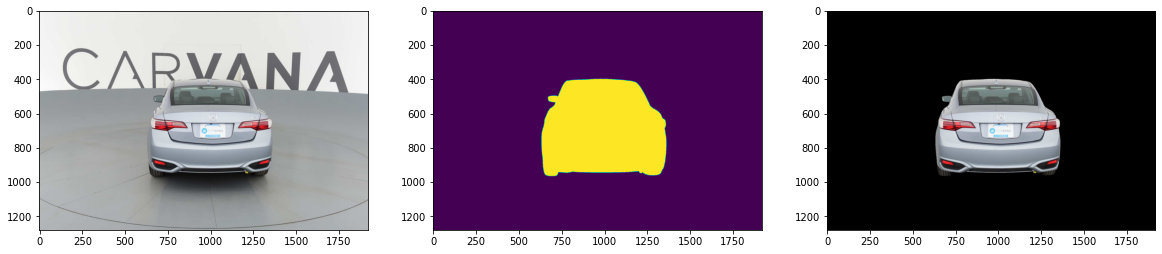

In [15]:
# Display single car with associated mask

# Get image and mask
path_to_mask = GetCarImageFiles(train_ids[0], get_mask=True)
mask = GetImageMatrix(path_to_mask[0])
path_to_image = GetCarImageFiles(train_ids[0])
image = GetImageMatrix(path_to_image[0])
dest_and = cv2.bitwise_and(image, image, mask=mask)

print("Image shape:", image.shape)
print("Image type:", image.dtype)
print("Mask shape:", mask.shape)
print("Mask type:", mask.dtype)

plt.figure(figsize=(20,20))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.subplot(1, 3, 2)
plt.imshow(mask)
plt.subplot(1, 3, 3)
plt.imshow(dest_and)

In [16]:
# Defining the model
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

layer_names = [
  'block_1_expand_relu',
  'block_3_expand_relu',
  'block_6_expand_relu',
  'block_13_expand_relu',
  'block_16_project'
]

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [21]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [22]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [23]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

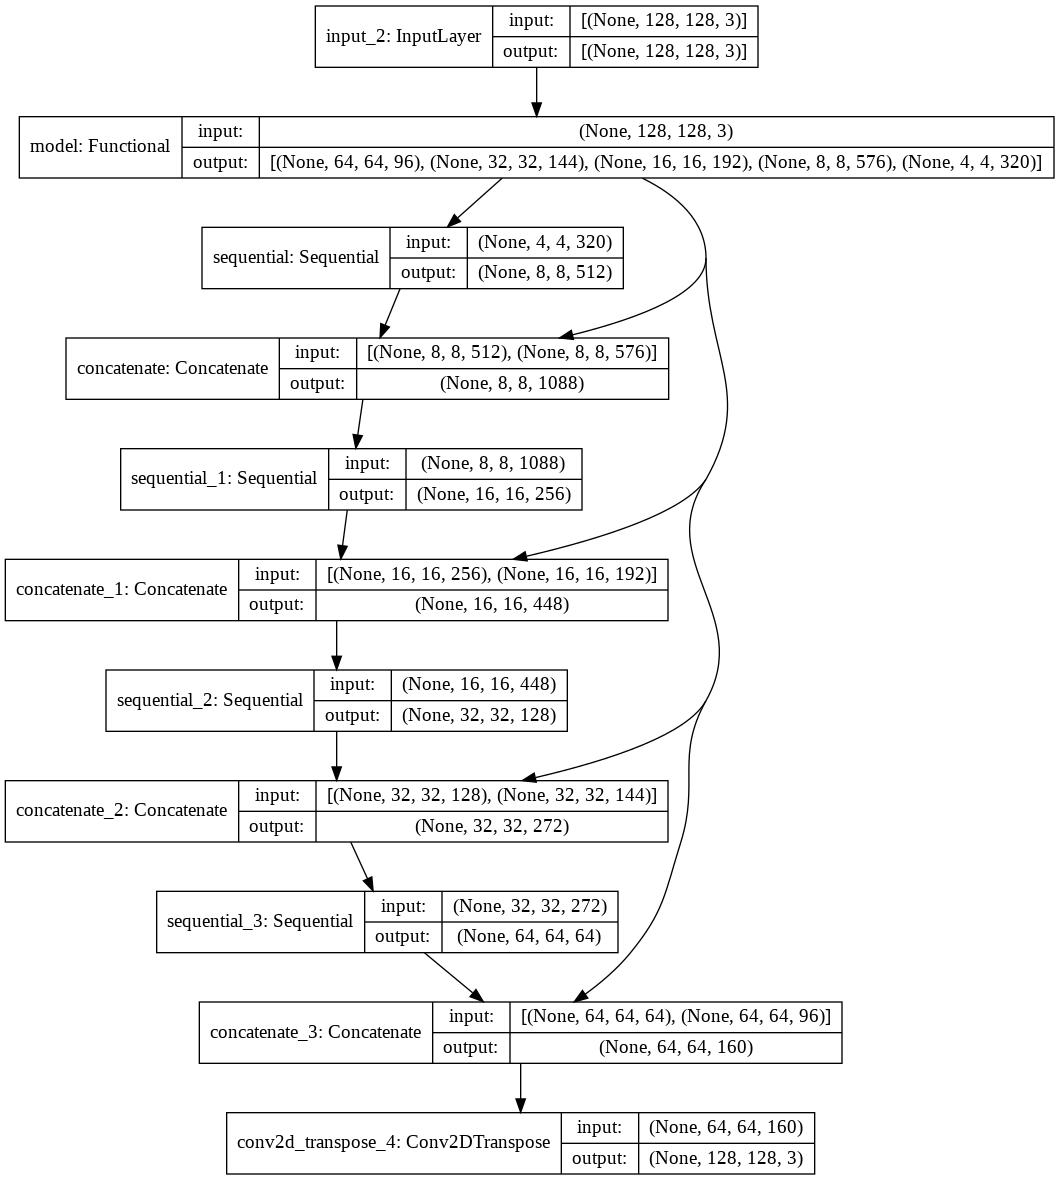

In [24]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [25]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
[]  return pred_mask[0]

In [26]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
# for images, masks

In [27]:
show_predictions()


NameError: ignored